# Baseline Model

Below we have the baseline model using an SVM network.

In [1]:
"""
Baseline Model - SVM
"""

import cv2
import numpy as np
import os

from sklearn import linear_model, metrics, svm 
from sklearn.model_selection import train_test_split

np.random.seed(0)
RANDOM_NUM = np.random.randint(1000)

In [2]:
DATA_PATH = "KLARR_NET_data/fer_2013"

IMG_WIDTH = 48
IMG_HEIGHT = 48

def create_dataset(img_folder):
    """ Creates a dataset of the images in the given folder and returns the
    data and labels array.
    """
    img_data_array = []
    class_name = []
   
    for class_num, dir in enumerate(os.listdir(img_folder)):
        print(f"Class Num: {class_num}, Directory: {dir}")

        for i, filename in enumerate(os.listdir(os.path.join(img_folder, dir))):
            if i % 1000 == 0:
                print(i)

            # Read the image in grayscale
            image_path = os.path.join(img_folder, dir, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(
                image,
                (IMG_HEIGHT, IMG_WIDTH),
                interpolation=cv2.INTER_AREA
            )

            # Convert to numpy and normalize between 0 and 1
            image = np.array(image).astype('float32').flatten() / 255

            img_data_array.append(image)
            class_name.append(class_num)

    return np.array(img_data_array), np.array(class_name)

X_train, y_train = create_dataset(DATA_PATH)
X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    train_size=0.7,
    random_state=RANDOM_NUM)

Class Num: 0, Directory: angry
0
1000
2000
3000
4000
Class Num: 1, Directory: fear
0
1000
2000
3000
4000
5000
Class Num: 2, Directory: happy
0
1000
2000
3000
4000
5000
Class Num: 3, Directory: neutral
0
1000
2000
3000
4000
5000
6000
Class Num: 4, Directory: sad
0
1000
2000
3000
4000
5000
6000
Class Num: 5, Directory: surprise
0
1000
2000
3000


In [3]:
CLASSES = ['angry', 'fear', 'happy' ,'neutral' ,'sad' ,'surprise']

def print_class_distribution_in_dataset(dataset_labels):
    num_classes = [0] * len(CLASSES)
    for label in dataset_labels:
        num_classes[label] += 1
    
    for i, num_of_class in enumerate(num_classes):
        print(f"Class: {CLASSES[i]}, Number of Classes: {num_of_class}")

print(f"Baseline Model Training Set Size: {len(X_train)}")
print_class_distribution_in_dataset(y_train)

print(f"\nBaseline Model Test Set Size: {len(X_test)}")
print_class_distribution_in_dataset(y_test)


Baseline Model Training Set Size: 22405
Class: angry, Number of Classes: 3466
Class: fear, Number of Classes: 3532
Class: happy, Number of Classes: 3984
Class: neutral, Number of Classes: 4364
Class: sad, Number of Classes: 4252
Class: surprise, Number of Classes: 2807

Baseline Model Test Set Size: 9603
Class: angry, Number of Classes: 1451
Class: fear, Number of Classes: 1545
Class: happy, Number of Classes: 1801
Class: neutral, Number of Classes: 1822
Class: sad, Number of Classes: 1810
Class: surprise, Number of Classes: 1174


In [4]:
from joblib import dump, load
from pathlib import Path

MODELS_DIR = "models"

def train_and_test_baseline(model):
    """ Fits model to training data and prints information about its accuracy
    with respect to test data.
    """
    model.fit(X_train, y_train)

    # Test its accuracy on testing data
    y_pred = model.predict(X_test)
    classification_report = metrics.classification_report(y_test, y_pred)
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

    baseline_test_acc = model.score(X_test, y_test)
    print(f"Baseline Model Test Accuracy: {baseline_test_acc}")

    print(f"Classification report for classifier {model}:")
    print(f"\n{classification_report}")

    print(f"\nConfusion matrix:\n\n{confusion_matrix}")

def save_baseline(model, name):
    file_name = f"baseline_model_{name}.joblib"
    model_location = os.path.join(MODELS_DIR, file_name)

    Path(MODELS_DIR).mkdir(parents=True, exist_ok=True)
    dump(model, model_location)

    # To load the model, use this expression
    # clf = load(model_location)

In [5]:
baseline_model_1 = linear_model.SGDClassifier(
    loss='log',
    n_jobs=-1,
    random_state=RANDOM_NUM
)

train_and_test_baseline(baseline_model_1)

Baseline Model Test Accuracy: 0.28157867333125064
Classification report for classifier SGDClassifier(loss='log', n_jobs=-1, random_state=684):

              precision    recall  f1-score   support

           0       0.27      0.16      0.20      1451
           1       0.21      0.29      0.24      1545
           2       0.46      0.30      0.36      1801
           3       0.33      0.21      0.25      1822
           4       0.32      0.13      0.18      1810
           5       0.25      0.75      0.37      1174

    accuracy                           0.28      9603
   macro avg       0.30      0.31      0.27      9603
weighted avg       0.31      0.28      0.27      9603


Confusion matrix:

[[232 365 164 143 111 436]
 [123 444 102 150 101 625]
 [153 359 540 182 108 459]
 [129 374 170 377 152 620]
 [196 482 148 241 231 512]
 [ 40 129  42  57  26 880]]


In [6]:
baseline_model_2 = linear_model.SGDClassifier(
    n_jobs=-1,
    random_state=RANDOM_NUM
)

train_and_test_baseline(baseline_model_2)

bm2_params = baseline_model_2.get_params()
save_baseline(
    baseline_model_2,
    f"SGDClassifier_randomstate-{bm2_params['random_state']}"
)

Baseline Model Test Accuracy: 0.2869936478183901
Classification report for classifier SGDClassifier(n_jobs=-1, random_state=684):

              precision    recall  f1-score   support

           0       0.29      0.11      0.16      1451
           1       0.25      0.19      0.21      1545
           2       0.45      0.24      0.32      1801
           3       0.24      0.66      0.35      1822
           4       0.28      0.19      0.23      1810
           5       0.56      0.27      0.36      1174

    accuracy                           0.29      9603
   macro avg       0.35      0.28      0.27      9603
weighted avg       0.34      0.29      0.27      9603


Confusion matrix:

[[ 159  184  152  722  194   40]
 [  90  291   85  786  188  105]
 [  90  155  441  907  182   26]
 [  77  164  116 1210  213   42]
 [  95  230  127  983  343   32]
 [  31  156   55  532   88  312]]


In [7]:
baseline_model_3 = svm.LinearSVC(
    dual=False,
    C=100,
    max_iter=20,
    random_state=RANDOM_NUM,
)

train_and_test_baseline(baseline_model_3)

bm3_params = baseline_model_3.get_params()
save_baseline(
    baseline_model_3,
    f"LinearSVC_dual-{bm3_params['dual']}_C-{bm3_params['C']}_"
    f"iters-{bm3_params['max_iter']}_randomstate-{bm3_params['random_state']}"
)

Baseline Model Test Accuracy: 0.32541913985212956
Classification report for classifier LinearSVC(C=100, dual=False, max_iter=20, random_state=684):

              precision    recall  f1-score   support

           0       0.25      0.19      0.22      1451
           1       0.24      0.18      0.21      1545
           2       0.41      0.46      0.43      1801
           3       0.30      0.35      0.32      1822
           4       0.29      0.29      0.29      1810
           5       0.42      0.49      0.45      1174

    accuracy                           0.33      9603
   macro avg       0.32      0.33      0.32      9603
weighted avg       0.32      0.33      0.32      9603


Confusion matrix:

[[279 174 276 294 297 131]
 [187 277 223 306 288 264]
 [165 144 832 298 253 109]
 [174 198 288 642 352 168]
 [217 230 294 420 525 124]
 [ 79 111 141 169 104 570]]


In [8]:
baseline_model_4 = linear_model.SGDClassifier(
    n_jobs=-1,
    learning_rate='invscaling',
    eta0=0.005,
    random_state=RANDOM_NUM,
)

train_and_test_baseline(baseline_model_4)

bm4_params = baseline_model_4.get_params()
save_baseline(
    baseline_model_4,
    f"SGDClassifier_lr-{bm4_params['learning_rate']}_eta0-{bm4_params['eta0']}_"
    f"randomstate-{bm4_params['random_state']}"
)

Baseline Model Test Accuracy: 0.3498906591690097
Classification report for classifier SGDClassifier(eta0=0.005, learning_rate='invscaling', n_jobs=-1,
              random_state=684):

              precision    recall  f1-score   support

           0       0.25      0.24      0.25      1451
           1       0.28      0.10      0.15      1545
           2       0.40      0.59      0.48      1801
           3       0.32      0.50      0.39      1822
           4       0.33      0.24      0.27      1810
           5       0.52      0.40      0.45      1174

    accuracy                           0.35      9603
   macro avg       0.35      0.34      0.33      9603
weighted avg       0.35      0.35      0.33      9603


Confusion matrix:

[[ 346   72  368  381  202   82]
 [ 274  159  308  448  207  149]
 [ 177   62 1054  316  147   45]
 [ 176   82  356  910  231   67]
 [ 280   97  353  566  426   88]
 [ 116   90  168  255   80  465]]


# CNN Implementation

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import torch

from torchvision import datasets, transforms

np.random.seed(0)
torch.manual_seed(1000)
RANDOM_NUM = np.random.randint(1000)

In [10]:
CLASSES = None

def print_class_distribution_in_dataset(dataset_labels):
    num_classes = [0] * len(CLASSES)
    for label in dataset_labels:
        num_classes[label] += 1
    
    for i, num_of_class in enumerate(num_classes):
        print(f"Class: {CLASSES[i]}, Number of Classes: {num_of_class}")

In [11]:
IMG_WIDTH = 48
IMG_HEIGHT = 48

DATA_PATH = "KLARR_NET_data/fer_2013"

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    ])

total_data = datasets.ImageFolder(root=DATA_PATH, transform=TRANSFORM_IMG)
total_data_len = len(total_data)
CLASSES = total_data.classes

print('Number of Images : ', total_data_len)
print_class_distribution_in_dataset(total_data.targets)

Number of Images :  32008
Class: angry, Number of Classes: 4917
Class: fear, Number of Classes: 5077
Class: happy, Number of Classes: 5785
Class: neutral, Number of Classes: 6186
Class: sad, Number of Classes: 6062
Class: surprise, Number of Classes: 3981


In [12]:
train_data_len = int(total_data_len * 0.7)
valid_data_len = int(total_data_len * 0.15)
test_data_len = total_data_len - train_data_len - valid_data_len

train_data, valid_data, test_data = torch.utils.data.random_split(
    total_data,
    (train_data_len, valid_data_len, test_data_len)
)

print(f"Number of Training Images: {len(train_data)}")
print_class_distribution_in_dataset([datapoint[1] for datapoint in train_data])

print(f"\nNumber of Validation Images: {len(valid_data)}")
print_class_distribution_in_dataset([datapoint[1] for datapoint in valid_data])

print(f"\nNumber of Test Images: {len(test_data)}")
print_class_distribution_in_dataset([datapoint[1] for datapoint in test_data])


Number of Training Images: 22405
Class: angry, Number of Classes: 3441
Class: fear, Number of Classes: 3571
Class: happy, Number of Classes: 4096
Class: neutral, Number of Classes: 4284
Class: sad, Number of Classes: 4294
Class: surprise, Number of Classes: 2719

Number of Validation Images: 4801
Class: angry, Number of Classes: 734
Class: fear, Number of Classes: 755
Class: happy, Number of Classes: 867
Class: neutral, Number of Classes: 919
Class: sad, Number of Classes: 896
Class: surprise, Number of Classes: 630

Number of Test Images: 4802
Class: angry, Number of Classes: 742
Class: fear, Number of Classes: 751
Class: happy, Number of Classes: 822
Class: neutral, Number of Classes: 983
Class: sad, Number of Classes: 872
Class: surprise, Number of Classes: 632


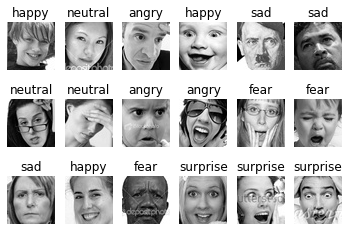

In [13]:
i = 0
printed_images = {i: 0 for i in range(6)}

for img, label in torch.utils.data.DataLoader(train_data, batch_size=1):
    class_num = label[0].item()
    
    if printed_images[class_num] == 3:
        continue
    if i == 18:
        break

    plt.subplot(3, 6, i+1)
    plt.axis('off')
    plt.title(CLASSES[class_num])
    plt.imshow(img.squeeze(), cmap='gray')

    printed_images[class_num] += 1
    i += 1

In [14]:
import itertools

from datetime import datetime
from sklearn.metrics import confusion_matrix

USE_CUDA = torch.cuda.is_available()

def get_model_name(name, batch_size, learning_rate, iteration):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_iter{3}_date{4}".format(
      name,
      batch_size,
      learning_rate,
      iteration,
      datetime.now().strftime("%d_%m_%Y-%H_%M")
    )
    return path

def get_accuracy(model, data_loader, dropout=False):
    if(dropout):
        model.eval()
    correct, total = 0, 0

    for imgs, labels in data_loader:
      if USE_CUDA:
          imgs = imgs.cuda()
          labels = labels.cuda()

      out = model(imgs)
      pred = out.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]

    if(dropout):
        model.train()
    return correct / total

def plot_confusion_matrix(
    model,
    data,
    title="Confusion Matrix",
    normalize=True,
    cmap=plt.cm.Blues
):
    classes = data.dataset.classes

    # Find true and predicted values for the given data
    y_pred = [None] * len(data)
    y_true = [None] * len(data)

    for i, index in enumerate(data.indices):
        X = data.dataset[index][0].unsqueeze(0)

        if USE_CUDA:
            X = X.cuda()

        y_pred[i] = classes[model(X).max(1, keepdim=True)[1].item()]
        y_true[i] = classes[data.dataset[index][1]]

    # Find confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot colourful confusion matrix
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

def train(
    model,
    train_data,
    val_data,
    batch_size=512,
    learning_rate=0.001,
    iterations=10,
    decay=0,
    dropout=False,
    save=True
):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)

    train_loss, train_acc, val_acc = [], [], []

    train_loader = torch.utils.data.DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=0
    )
    val_loader = torch.utils.data.DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )

    for iteration in range(iterations):
        iter_loss = float(0)
        for imgs, labels in train_loader:
            if USE_CUDA:
                imgs = imgs.cuda()
                labels = labels.cuda()

            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            iter_loss += float(loss.item())

        # Compute training/validation accuracy/loss
        train_loss.append(iter_loss / len(train_loader))
        train_acc.append(get_accuracy(model, train_loader, dropout=dropout))
        val_acc.append(get_accuracy(model, val_loader, dropout=dropout))

        # Save model progress
        if save:
            model_path = get_model_name(model.name, batch_size, learning_rate, iteration)
            torch.save(model.eval().state_dict(), f"models/{model_path}")

        print(("Iteration {}: Train loss: {}, Train accuracy: {}"
              " | Validation accuracy: {}").format(
                iteration + 1,
                train_loss[-1],
                train_acc[-1],
                val_acc[-1]
        ))

    # Plot model training information
    plt.title("Loss Curves")
    plt.plot(range(1, iterations+1), train_loss, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Accuracy Curves")
    plt.plot(range(1, iterations+1), train_acc, label="Train")
    plt.plot(range(1, iterations+1), val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    plot_confusion_matrix(model, valid_data, title="Model Confusion Matrix (Validation)")

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class KLARR_NET(nn.Module):
    def __init__(self):
        super(KLARR_NET, self).__init__()
        self.name = 'KLARR_NET'

        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 5, 5)
        self.conv2 = nn.Conv2d(5, 10, 5)

        self.fc1 = nn.Linear(9*9*10, 72)
        self.fc2 = nn.Linear(72, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Linear layers
        x = x.view(-1, 9*9*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

Iteration 1: Train loss: 1.7700745463371277, Train accuracy: 0.25900468645391655 | Validation accuracy: 0.24765673817954592
Iteration 2: Train loss: 1.6872139058329843, Train accuracy: 0.3105110466413747 | Validation accuracy: 0.2993126431993335
Iteration 3: Train loss: 1.6311603296886792, Train accuracy: 0.33010488730194154 | Validation accuracy: 0.32180795667569256
Iteration 4: Train loss: 1.6086434803225778, Train accuracy: 0.34728855166257533 | Validation accuracy: 0.33826286190377003
Iteration 5: Train loss: 1.5860833390192552, Train accuracy: 0.37339879491185 | Validation accuracy: 0.3576338262861904
Iteration 6: Train loss: 1.5657391087575392, Train accuracy: 0.3854496764115153 | Validation accuracy: 0.3682566132055822
Iteration 7: Train loss: 1.550731740214608, Train accuracy: 0.39018076322249495 | Validation accuracy: 0.37513018121224745
Iteration 8: Train loss: 1.5295695039359005, Train accuracy: 0.39642936844454363 | Validation accuracy: 0.3765882107894189
Iteration 9: Train

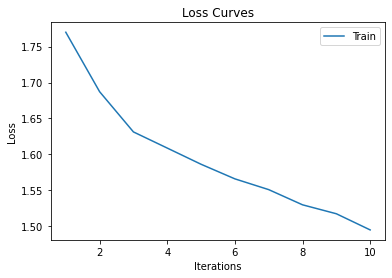

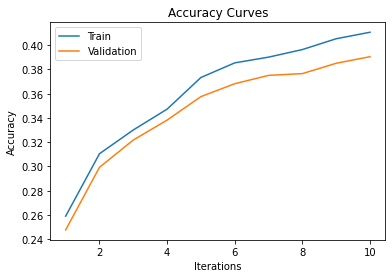

Final Training Accuracy: 0.4107118946663691
Final Validation Accuracy: 0.3905436367423453


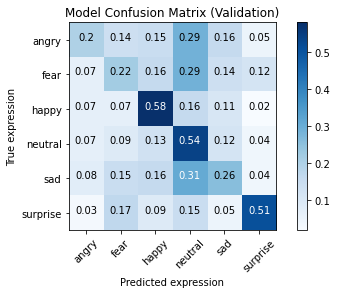

In [16]:
model1 = KLARR_NET()

if USE_CUDA:
    model1 = model1.cuda()

train(model1, train_data, valid_data, save=False)

Iteration 1: Train loss: 1.7051131942055442, Train accuracy: 0.36389198839544745 | Validation accuracy: 0.3451364299104353
Iteration 2: Train loss: 1.516554783013734, Train accuracy: 0.4241017629993305 | Validation accuracy: 0.38971047698396166
Iteration 3: Train loss: 1.432404207235033, Train accuracy: 0.45904931934835974 | Validation accuracy: 0.41887106852739014
Iteration 4: Train loss: 1.378074469214136, Train accuracy: 0.4711894666369114 | Validation accuracy: 0.42303686731930845
Iteration 5: Train loss: 1.3274432579902085, Train accuracy: 0.4902477125641598 | Validation accuracy: 0.43824203290981045
Iteration 6: Train loss: 1.2956511147997596, Train accuracy: 0.5137246150412854 | Validation accuracy: 0.4401166423661737
Iteration 7: Train loss: 1.2693435712294145, Train accuracy: 0.5246596741798706 | Validation accuracy: 0.43553426369506354
Iteration 8: Train loss: 1.2366511083462022, Train accuracy: 0.5147065387190359 | Validation accuracy: 0.4305353051447615
Iteration 9: Train l

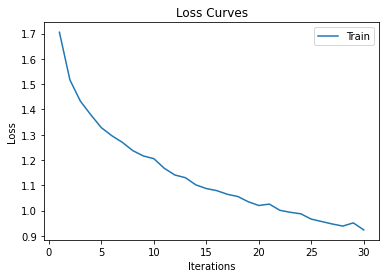

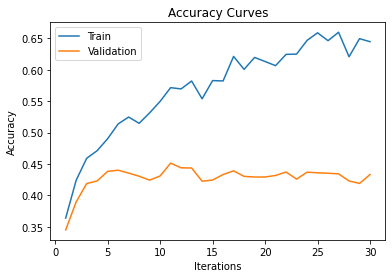

Final Training Accuracy: 0.6445436286543182
Final Validation Accuracy: 0.43324307435950843


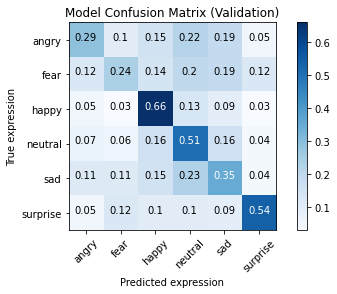

In [17]:
model2 = KLARR_NET()

if USE_CUDA:
    model2 = model2.cuda()

train(
    model2,
    train_data,
    valid_data,
    learning_rate=0.005, 
    batch_size=128,
    iterations=30
)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class KLARR_NET2(nn.Module):
    def __init__(self):
        super(KLARR_NET2, self).__init__()
        self.name = 'KLARR_NET2'

        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 15, 5)
        self.conv2 = nn.Conv2d(15, 30, 3)
        self.conv3 = nn.Conv2d(30, 45, 2)

        self.fc1 = nn.Linear(4*4*45, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Linear layers
        x = x.view(-1, 4*4*45)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

Iteration 1: Train loss: 1.7130487737330524, Train accuracy: 0.34487837536264226 | Validation accuracy: 0.3315975838367007
Iteration 2: Train loss: 1.6020396162163129, Train accuracy: 0.35826824369560367 | Validation accuracy: 0.3403457612997292
Iteration 3: Train loss: 1.5545644096352838, Train accuracy: 0.3961169381834412 | Validation accuracy: 0.38158716933972087
Iteration 4: Train loss: 1.5078234713185916, Train accuracy: 0.4016960499888418 | Validation accuracy: 0.388877317225578
Iteration 5: Train loss: 1.4686216549439863, Train accuracy: 0.4270029011381388 | Validation accuracy: 0.4072068319100187
Iteration 6: Train loss: 1.4362128268588672, Train accuracy: 0.43874135237670164 | Validation accuracy: 0.4109560508227453
Iteration 7: Train loss: 1.4092928672378713, Train accuracy: 0.4579781298817228 | Validation accuracy: 0.42157883774213706
Iteration 8: Train loss: 1.3713587725704366, Train accuracy: 0.47181432715911625 | Validation accuracy: 0.43720058321183086
Iteration 9: Train

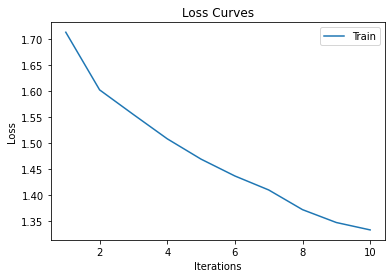

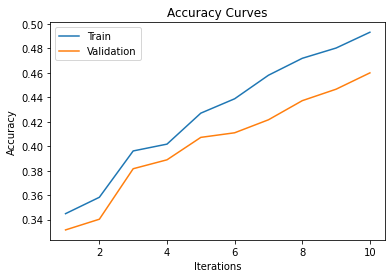

Final Training Accuracy: 0.49310421780852487
Final Validation Accuracy: 0.45990418662778587


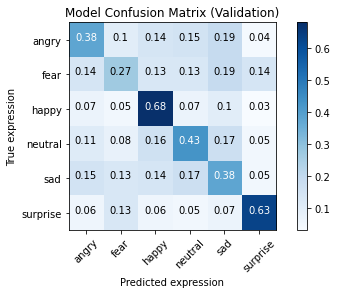

In [19]:
model3 = KLARR_NET()

if USE_CUDA:
    model3 = model3.cuda()

train(
    model3,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=10
)

Iteration 1: Train loss: 1.7367499199780552, Train accuracy: 0.2886409283642044 | Validation accuracy: 0.277858779420954
Iteration 2: Train loss: 1.6082251410592685, Train accuracy: 0.36308859629546975 | Validation accuracy: 0.34805248906477815
Iteration 3: Train loss: 1.490975943478671, Train accuracy: 0.4250390537826378 | Validation accuracy: 0.39887523432618205
Iteration 4: Train loss: 1.414508113806898, Train accuracy: 0.450167373354162 | Validation accuracy: 0.4209539679233493
Iteration 5: Train loss: 1.3483702432025562, Train accuracy: 0.4893996875697389 | Validation accuracy: 0.4471985003124349
Iteration 6: Train loss: 1.2972729002887553, Train accuracy: 0.4826154876143718 | Validation accuracy: 0.43595084357425534
Iteration 7: Train loss: 1.2566177546977997, Train accuracy: 0.5298370899352823 | Validation accuracy: 0.46844407415121847
Iteration 8: Train loss: 1.1988715773279017, Train accuracy: 0.5594733318455701 | Validation accuracy: 0.48677358883565924
Iteration 9: Train los

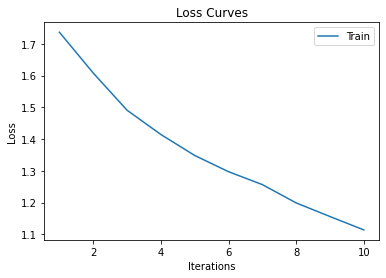

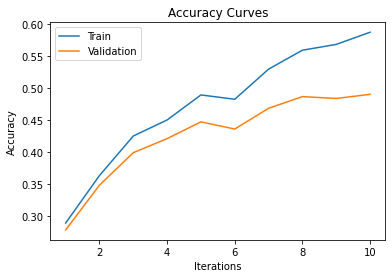

Final Training Accuracy: 0.5876366882392323
Final Validation Accuracy: 0.4903145178087898


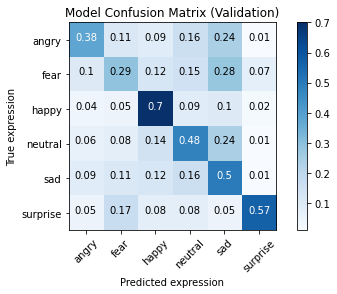

In [20]:
model4 = KLARR_NET2()

if USE_CUDA:
    model4 = model4.cuda()

train(
    model4,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=10
)

Iteration 1: Train loss: 1.7282958626747131, Train accuracy: 0.2916759651863423 | Validation accuracy: 0.28244115809206416
Iteration 2: Train loss: 1.6143032989718697, Train accuracy: 0.3567507252845347 | Validation accuracy: 0.3511768381587169
Iteration 3: Train loss: 1.5130901526321063, Train accuracy: 0.4134345012274046 | Validation accuracy: 0.39991668402416164
Iteration 4: Train loss: 1.4384320418943057, Train accuracy: 0.4469984378486945 | Validation accuracy: 0.4288689856279942
Iteration 5: Train loss: 1.367500975728035, Train accuracy: 0.4665922785092613 | Validation accuracy: 0.43699229327223493
Iteration 6: Train loss: 1.3220123824748127, Train accuracy: 0.49078330729747827 | Validation accuracy: 0.4446990210372839
Iteration 7: Train loss: 1.263267695903778, Train accuracy: 0.5242579781298817 | Validation accuracy: 0.45490522807748385
Iteration 8: Train loss: 1.210572974248366, Train accuracy: 0.5451015398348583 | Validation accuracy: 0.4805248906477817
Iteration 9: Train los

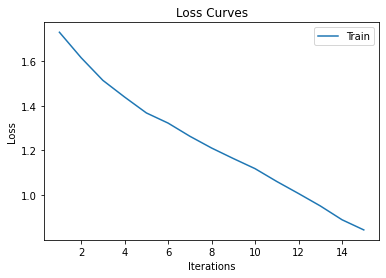

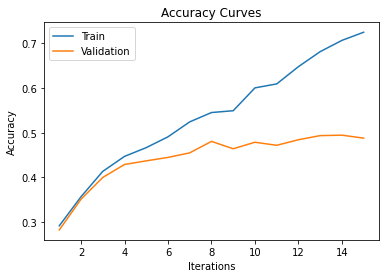

Final Training Accuracy: 0.7247935728632002
Final Validation Accuracy: 0.48781503853363883


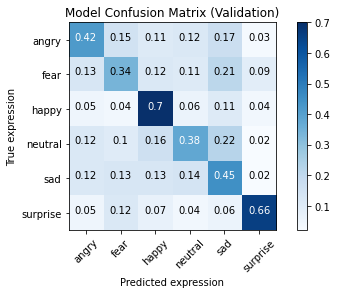

In [21]:
model5 = KLARR_NET2()

if USE_CUDA:
    model5 = model5.cuda()

train(
    model5,
    train_data,
    valid_data,
    learning_rate=0.003,
    batch_size=256,
    iterations=15
)

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class KLARR_NET3(nn.Module):
    def __init__(self):
        super(KLARR_NET3, self).__init__()
        self.name = 'KLARR_NET3'

        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 30, 4, padding=2)
        self.conv2 = nn.Conv2d(30, 60, 3, padding=2)
        self.conv3 = nn.Conv2d(60, 90, 2, padding=2)

        self.fc1 = nn.Linear(8*8*90, 125)
        self.fc2 = nn.Linear(125, 50)
        self.fc3 = nn.Linear(50, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Linear layers
        x = x.view(-1,8*8*90)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

Iteration 1: Train loss: 1.7156890671361575, Train accuracy: 0.30997545190805625 | Validation accuracy: 0.2999375130181212
Iteration 2: Train loss: 1.5611131611195477, Train accuracy: 0.4087480473108681 | Validation accuracy: 0.3876275775880025
Iteration 3: Train loss: 1.4504622722213918, Train accuracy: 0.4452131220709663 | Validation accuracy: 0.4176213288898146
Iteration 4: Train loss: 1.3589971417730504, Train accuracy: 0.4873912073197947 | Validation accuracy: 0.4492813997083941
Iteration 5: Train loss: 1.278213686563752, Train accuracy: 0.5208658781521982 | Validation accuracy: 0.4651114351176838
Iteration 6: Train loss: 1.2177133912389928, Train accuracy: 0.5572416871234099 | Validation accuracy: 0.484898979379296
Iteration 7: Train loss: 1.1631500924175435, Train accuracy: 0.5860745369337201 | Validation accuracy: 0.4969797958758592
Iteration 8: Train loss: 1.084775635464625, Train accuracy: 0.6273153313992412 | Validation accuracy: 0.512393251405957
Iteration 9: Train loss: 1.

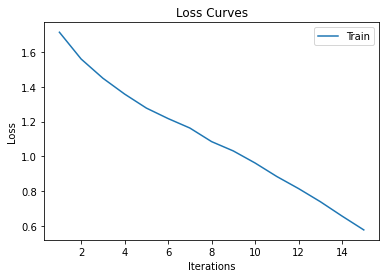

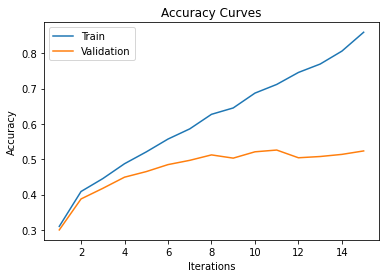

Final Training Accuracy: 0.8597634456594511
Final Validation Accuracy: 0.5236409081441367


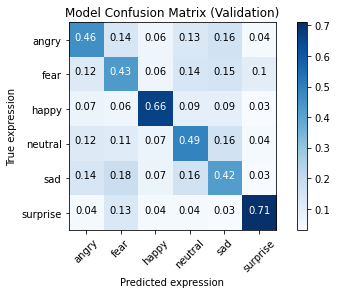

In [23]:
model6 = KLARR_NET3()

if USE_CUDA:
    model6 = model6.cuda()

train(
    model6,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=15
)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class KLARR_NET4(nn.Module):
    def __init__(self):
        super(KLARR_NET4, self).__init__()
        self.name = 'KLARR_NET4'

        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 30, 4, padding=2)
        self.conv2 = nn.Conv2d(30, 60, 3, padding=2)
        self.conv3 = nn.Conv2d(60, 90, 2, padding=2)

        '''
        48x48 (1ch) --> conv1 --> 49x49 (30ch)
        49x49 (30ch) --> maxpool --> 24x24 (30ch)
        24x24 (30ch) --> conv2 --> 26x26 (60ch)
        26x26 (60ch) --> maxpool --> 13x13 (60ch)
        13x13 (60ch) --> conv3 --> 16x16 (90ch)
        16x16 (90ch) --> maxpool --> 8x8 (90ch)
        '''

        self.fc1 = nn.Linear(8*8*90, 75)
        self.fc2 = nn.Linear(75, 20)
        self.fc3 = nn.Linear(20, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Linear layers
        x = x.view(-1,8*8*90)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

Iteration 1: Train loss: 1.7479962002147327, Train accuracy: 0.27480473108681097 | Validation accuracy: 0.26348677358883565
Iteration 2: Train loss: 1.6361876726150513, Train accuracy: 0.3259093952242803 | Validation accuracy: 0.31097687981670485
Iteration 3: Train loss: 1.550002466548573, Train accuracy: 0.4044632894443205 | Validation accuracy: 0.38596125807123516
Iteration 4: Train loss: 1.4718718474561518, Train accuracy: 0.42941307743807183 | Validation accuracy: 0.40158300354092896
Iteration 5: Train loss: 1.4068850861354307, Train accuracy: 0.43700066949341665 | Validation accuracy: 0.4067902520308269
Iteration 6: Train loss: 1.3529578609900041, Train accuracy: 0.48596295469761214 | Validation accuracy: 0.4449073109768798
Iteration 7: Train loss: 1.3014985593882473, Train accuracy: 0.4982816335639366 | Validation accuracy: 0.4465736304936472
Iteration 8: Train loss: 1.2638219594955444, Train accuracy: 0.518232537380049 | Validation accuracy: 0.4536554884399083
Iteration 9: Train

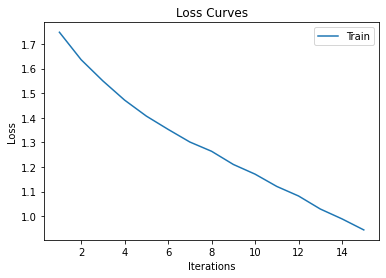

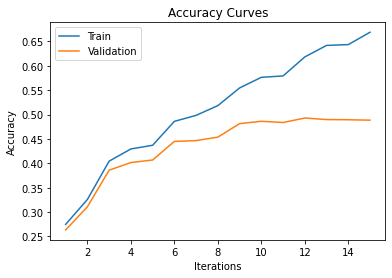

Final Training Accuracy: 0.6686453916536488
Final Validation Accuracy: 0.48843990835242657


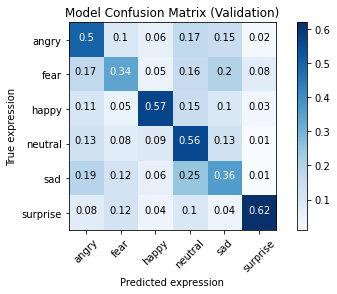

In [25]:
model7 = KLARR_NET4()

if USE_CUDA:
    model7 = model7.cuda()

train(
    model7,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=15
)

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class KLARR_NET5(nn.Module):
    def __init__(self):
        super(KLARR_NET5, self).__init__()
        self.name = 'KLARR_NET5'

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc_input = 4*4*256

        self.fc = nn.Sequential(
            nn.Linear(self.fc_input, 75),
            nn.ReLU(),

            nn.Linear(75, 20),
            nn.ReLU(),

            nn.Linear(20, 6)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x.view(-1, self.fc_input))
        return x

Iteration 1: Train loss: 1.7513023912906647, Train accuracy: 0.28069627315331397 | Validation accuracy: 0.2768173297229744
Iteration 2: Train loss: 1.644849343733354, Train accuracy: 0.33479134121847803 | Validation accuracy: 0.310560299937513
Iteration 3: Train loss: 1.555814023722302, Train accuracy: 0.3930819013613033 | Validation accuracy: 0.3803374297021454
Iteration 4: Train loss: 1.4739528000354767, Train accuracy: 0.4286096853380942 | Validation accuracy: 0.39991668402416164
Iteration 5: Train loss: 1.411484264514663, Train accuracy: 0.4492747154652979 | Validation accuracy: 0.42595292647365135
Iteration 6: Train loss: 1.353087073022669, Train accuracy: 0.4736889087257309 | Validation accuracy: 0.45344719850031245
Iteration 7: Train loss: 1.3059178780425678, Train accuracy: 0.4922115599196608 | Validation accuracy: 0.45282232868152467
Iteration 8: Train loss: 1.2622843330556697, Train accuracy: 0.5233653202410177 | Validation accuracy: 0.4736513226411164
Iteration 9: Train loss

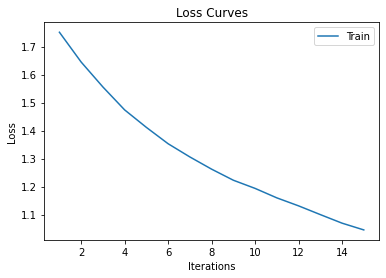

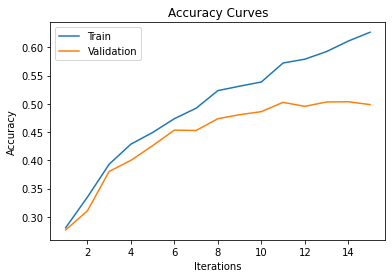

Final Training Accuracy: 0.6266904708770363
Final Validation Accuracy: 0.49864611539262654


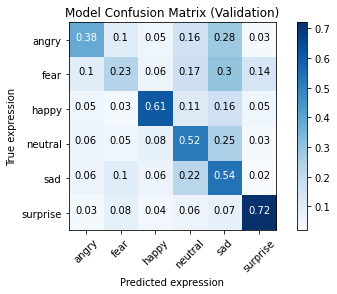

In [27]:
model8 = KLARR_NET5()

if USE_CUDA:
    model8 = model8.cuda()

train(
    model8,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=15
)

In [28]:
'''
The above models had a peak Validation Accuracy of 0.535 (KLARR_NET3, model 6, iter 13).
The previous 3 KLARR_NET architectures used a combination of 3 convolutional layers and 3 linear layers.
The following models will modify the original architecture by using research and proven successful tuning strategies.
'''

'\nThe above models had a peak Validation Accuracy of 0.535 (KLARR_NET3, model 6, iter 13).\nThe previous 3 KLARR_NET architectures used a combination of 3 convolutional layers and 3 linear layers.\nThe following models will modify the original architecture by using research and proven successful tuning strategies.\n'

In [29]:
'''
Try increasing number of convolutional layers, with depth increasing with time.
Idea is that model will learn deeper features, while width of each layer is small (3x3).
Keep kernels 3x3 but increase output channels
Have 5 convolutional and 2 linear layers
'''

class KLARR_NET6(nn.Module):
    def __init__(self):
        super(KLARR_NET6, self).__init__()
        self.name = 'KLARR_NET6'

        self.maxpool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AvgPool2d(2,2)

        self.conv1 = nn.Conv2d(1, 16, 3, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=2)
        self.conv5 = nn.Conv2d(128, 150, 3, padding=2)

        '''
        48x48 (1ch) --> conv1 --> 50x50 (16ch)
        50x50 (16ch) --> maxpool --> 25x25 (16ch)
        25x25 (16ch) --> conv2 --> 27x27 (32ch)
        27x27 (32ch) --> maxpool --> 13x13 (32ch)
        13x13 (32ch) --> conv3 --> 15x15 (64ch)
        15x15 (64ch) --> maxpool --> 7x7 (64ch)
        7x7 (64ch) --> conv4 --> 9x9 (128ch)
        9x9 (128ch) --> maxpool --> 4x4 (128ch)
        4x4 (128ch) --> conv5 --> 6x6 (150ch)
        6x6 (150ch) --> avgpool --> 3x3 (150ch)
        '''

        self.fc1 = nn.Linear(3*3*150, 50)
        self.fc2 = nn.Linear(50, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.maxpool(F.relu(self.conv3(x)))
        x = self.maxpool(F.relu(self.conv4(x)))
        x = self.avgpool(F.relu(self.conv5(x)))

        # Linear layers
        x = x.view(-1,3*3*150)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)             # applies softmax activation on output

        return x

Iteration 1: Train loss: 1.7671471292322332, Train accuracy: 0.22548538272706986 | Validation accuracy: 0.22620287440116643
Iteration 2: Train loss: 1.7462261427532544, Train accuracy: 0.23539388529346128 | Validation accuracy: 0.23474276192459903
Iteration 3: Train loss: 1.7281640889969738, Train accuracy: 0.2769024771256416 | Validation accuracy: 0.267652572380754
Iteration 4: Train loss: 1.662703741680492, Train accuracy: 0.3309975451908056 | Validation accuracy: 0.31305977921266404
Iteration 5: Train loss: 1.5521234016526828, Train accuracy: 0.4127203749163133 | Validation accuracy: 0.3905436367423453
Iteration 6: Train loss: 1.4305680096149445, Train accuracy: 0.4519526891318902 | Validation accuracy: 0.41553842949385544
Iteration 7: Train loss: 1.3651662875305524, Train accuracy: 0.47243918768132115 | Validation accuracy: 0.43928348260779004
Iteration 8: Train loss: 1.29744100977074, Train accuracy: 0.5119392992635572 | Validation accuracy: 0.4624036659029369
Iteration 9: Train l

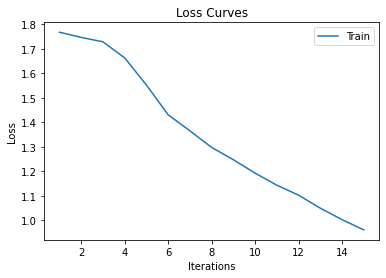

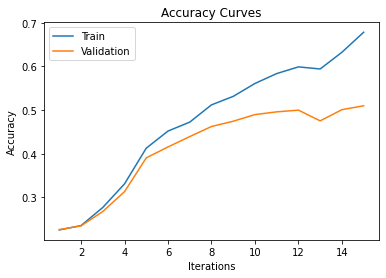

Final Training Accuracy: 0.6783307297478242
Final Validation Accuracy: 0.5098937721308061


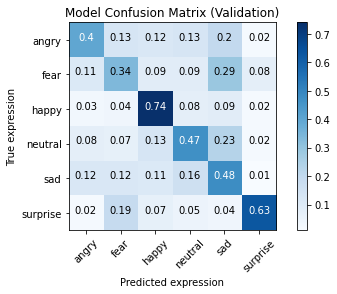

In [30]:
model6a = KLARR_NET6()

if USE_CUDA:
    model6a = model6a.cuda()

train(
    model6a,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=15
)

Iteration 1: Train loss: 1.767942034385421, Train accuracy: 0.21173845123856283 | Validation accuracy: 0.21724640699854197
Iteration 2: Train loss: 1.7442723485556515, Train accuracy: 0.23967864316000892 | Validation accuracy: 0.24557383878358674
Iteration 3: Train loss: 1.7302271642468192, Train accuracy: 0.28127650078107563 | Validation accuracy: 0.2755675900853989
Iteration 4: Train loss: 1.655667860399593, Train accuracy: 0.30778844008033923 | Validation accuracy: 0.30014580295771714
Iteration 5: Train loss: 1.578432091257789, Train accuracy: 0.37665699620620396 | Validation accuracy: 0.3507602582795251
Iteration 6: Train loss: 1.470869474790313, Train accuracy: 0.4293238116491854 | Validation accuracy: 0.41074776088314935
Iteration 7: Train loss: 1.4020503949035297, Train accuracy: 0.4611916982816336 | Validation accuracy: 0.4244948968964799
Iteration 8: Train loss: 1.344730626453053, Train accuracy: 0.4816781968310645 | Validation accuracy: 0.43574255363465947
Iteration 9: Train 

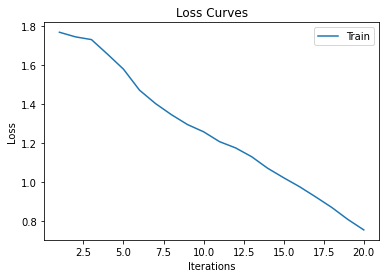

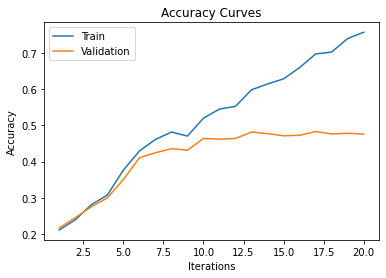

Final Training Accuracy: 0.7568399910734211
Final Validation Accuracy: 0.47594251197667153


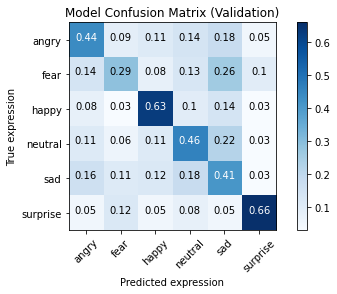

In [31]:
'''
Improvement between epochs, but slow.
Increase learning rate to reach min faster.
Increase number of iterations.
'''

model6b = KLARR_NET6()

if USE_CUDA:
    model6b = model6b.cuda()

train(
    model6b,
    train_data,
    valid_data,
    learning_rate=0.005,
    batch_size=256,
    iterations=20
)

In [32]:
'''
Use batch normalization layers to try to improve accuracy and speed up training.
Increase number of channels in final output layer.
Decrease learning rate to 0.001.

Could later use weight decay or dropout layers if we notice overfitting.
'''

class KLARR_NET7(nn.Module):
    def __init__(self):
        super(KLARR_NET7, self).__init__()
        self.name = 'KLARR_NET7'

        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm5 = nn.BatchNorm2d(256)

        self.maxpool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AvgPool2d(2,2)

        self.conv1 = nn.Conv2d(1, 16, 3, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=2)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=2)

        '''
        48x48 (1ch) --> conv1 --> 50x50 (16ch)
        50x50 (16ch) --> maxpool --> 25x25 (16ch)
        25x25 (16ch) --> conv2 --> 27x27 (32ch)
        27x27 (32ch) --> maxpool --> 13x13 (32ch)
        13x13 (32ch) --> conv3 --> 15x15 (64ch)
        15x15 (64ch) --> maxpool --> 7x7 (64ch)
        7x7 (64ch) --> conv4 --> 9x9 (128ch)
        9x9 (128ch) --> maxpool --> 4x4 (128ch)
        4x4 (128ch) --> conv5 --> 6x6 (256ch)
        6x6 (256ch) --> avgpool --> 3x3 (256ch)
        '''

        self.fc1 = nn.Linear(3*3*256, 50)
        self.fc2 = nn.Linear(50, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.batchnorm2(self.maxpool(F.relu(self.conv2(x))))
        x = self.maxpool(F.relu(self.conv3(x)))
        x = self.maxpool(F.relu(self.conv4(x)))
        x = self.batchnorm5(self.avgpool(F.relu(self.conv5(x))))

        # Linear layers
        x = x.view(-1,3*3*256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)             # applies softmax activation on output

        return x

Iteration 1: Train loss: 1.765885349024426, Train accuracy: 0.24766793126534256 | Validation accuracy: 0.25640491564257445
Iteration 2: Train loss: 1.748204223134301, Train accuracy: 0.24079446552108905 | Validation accuracy: 0.2316184128306603
Iteration 3: Train loss: 1.6774379299445585, Train accuracy: 0.32644498995759874 | Validation accuracy: 0.3041033118100396
Iteration 4: Train loss: 1.5294881720434537, Train accuracy: 0.41696049988841777 | Validation accuracy: 0.3980420745677984
Iteration 5: Train loss: 1.4025387926535173, Train accuracy: 0.4483374246819906 | Validation accuracy: 0.406581962091231
Iteration 6: Train loss: 1.3314529847015033, Train accuracy: 0.47627761660343676 | Validation accuracy: 0.44157467194334515
Iteration 7: Train loss: 1.2702771465886722, Train accuracy: 0.5038607453693372 | Validation accuracy: 0.4574047073526349
Iteration 8: Train loss: 1.20972800525752, Train accuracy: 0.5529122963624191 | Validation accuracy: 0.4946886065403041
Iteration 9: Train los

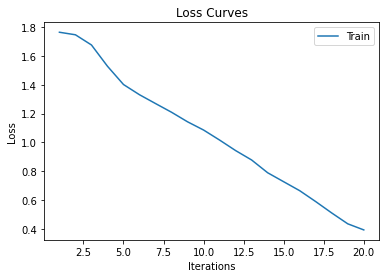

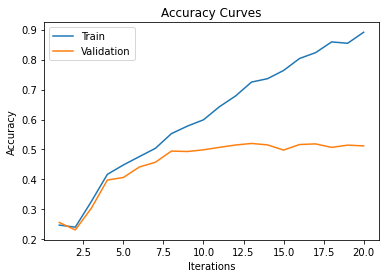

Final Training Accuracy: 0.8911850033474671
Final Validation Accuracy: 0.5119766715267653


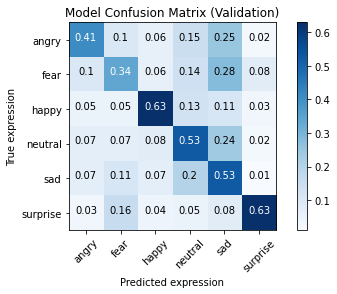

'\nThis model clearly underfits and does not improve after 8 iterations\n'

In [33]:
model7a = KLARR_NET7()

if USE_CUDA:
    model7a = model7a.cuda()

train(
    model7a,
    train_data,
    valid_data,
    learning_rate=0.001,
    batch_size=256,
    iterations=20
)

'''
This model clearly underfits and does not improve after 8 iterations
'''

Iteration 1: Train loss: 1.7396572523496368, Train accuracy: 0.29381834411961616 | Validation accuracy: 0.280358258696105
Iteration 2: Train loss: 1.6513318074020473, Train accuracy: 0.3343896451684892 | Validation accuracy: 0.3230576963132681
Iteration 3: Train loss: 1.5514067736538975, Train accuracy: 0.3361303280517742 | Validation accuracy: 0.32972297438033743
Iteration 4: Train loss: 1.4698311862620441, Train accuracy: 0.390403927694711 | Validation accuracy: 0.3701312226619454
Iteration 5: Train loss: 1.4316722750663757, Train accuracy: 0.38509261325596966 | Validation accuracy: 0.36075817538012916
Iteration 6: Train loss: 1.3722526573322036, Train accuracy: 0.40156215130551215 | Validation accuracy: 0.3747136013330556
Iteration 7: Train loss: 1.3509115942499854, Train accuracy: 0.4384735550100424 | Validation accuracy: 0.3920016663195168
Iteration 8: Train loss: 1.3041262274438685, Train accuracy: 0.44829279178754744 | Validation accuracy: 0.39887523432618205
Iteration 9: Train 

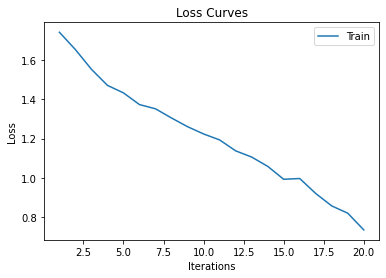

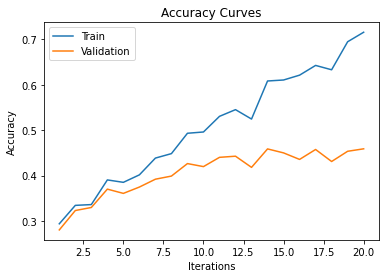

Final Training Accuracy: 0.7154652979245704
Final Validation Accuracy: 0.4588627369298063


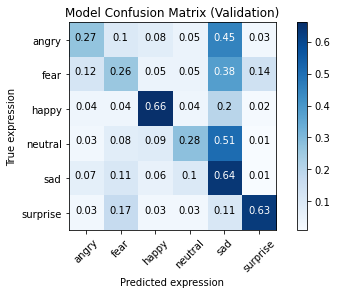

In [41]:
'''
Current best model: @ iteration 16, Validation accuracy: 0.5386377837950427
'''

model7d = KLARR_NET7()

if USE_CUDA:
    model7d = model7d.cuda()

train(
    model7d,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=128,
    iterations=20
)

In [35]:
'''
Increasing num of conv channels and adding batch normalization worked well
Training accuracy kept improving (up to 90%) but validation accuracy plateaued.

Exeriment with weight decay and dropout layers to try to resolve this overfitting issue.
'''

class KLARR_NET8(nn.Module):
    def __init__(self):
        super(KLARR_NET8, self).__init__()
        self.name = 'KLARR_NET8'

        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm5 = nn.BatchNorm2d(256)

        self.dropout_50 = nn.Dropout2d()
        self.dropout_25 = nn.Dropout2d(p=0.25)

        self.maxpool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AvgPool2d(2,2)

        self.conv1 = nn.Conv2d(1, 16, 3, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=2)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=2)

        '''
        48x48 (1ch) --> conv1 --> 50x50 (16ch)
        50x50 (16ch) --> maxpool --> 25x25 (16ch)
        25x25 (16ch) --> conv2 --> 27x27 (32ch)
        27x27 (32ch) --> maxpool --> 13x13 (32ch)
        13x13 (32ch) --> conv3 --> 15x15 (64ch)
        15x15 (64ch) --> maxpool --> 7x7 (64ch)
        7x7 (64ch) --> conv4 --> 9x9 (128ch)
        9x9 (128ch) --> maxpool --> 4x4 (128ch)
        4x4 (128ch) --> conv5 --> 6x6 (256ch)
        6x6 (256ch) --> avgpool --> 3x3 (256ch)
        '''

        self.fc1 = nn.Linear(3*3*256, 50)
        self.fc2 = nn.Linear(50, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.batchnorm2(self.maxpool(F.relu(self.conv2(x))))
        x = self.dropout_50(x)
        x = self.maxpool(F.relu(self.conv3(x)))
        x = self.maxpool(F.relu(self.conv4(x)))
        x = self.batchnorm5(self.avgpool(F.relu(self.conv5(x))))
        x = self.dropout_25(x)

        # Linear layers
        x = x.view(-1,3*3*256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)             # applies softmax activation on output

        return x

Iteration 1: Train loss: 1.7722540043971755, Train accuracy: 0.19562597634456594 | Validation accuracy: 0.189335555092689
Iteration 2: Train loss: 1.7528013160282916, Train accuracy: 0.2511046641374693 | Validation accuracy: 0.2486981878775255
Iteration 3: Train loss: 1.7139825265515933, Train accuracy: 0.26395893773711226 | Validation accuracy: 0.2593209747969173
Iteration 4: Train loss: 1.6294488866220822, Train accuracy: 0.2925686230752064 | Validation accuracy: 0.28993959591751717
Iteration 5: Train loss: 1.5761308907107874, Train accuracy: 0.35929480026779737 | Validation accuracy: 0.33701312226619456
Iteration 6: Train loss: 1.4930883083831181, Train accuracy: 0.39201071189466635 | Validation accuracy: 0.3780462403665903
Iteration 7: Train loss: 1.470881325277415, Train accuracy: 0.4328944432046418 | Validation accuracy: 0.40741512184961465
Iteration 8: Train loss: 1.3727868578650735, Train accuracy: 0.3728632001785316 | Validation accuracy: 0.35242657779629244
Iteration 9: Train

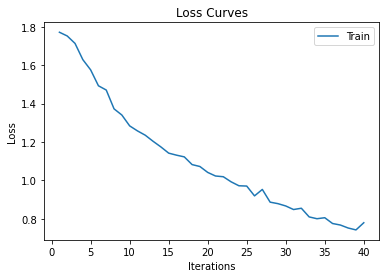

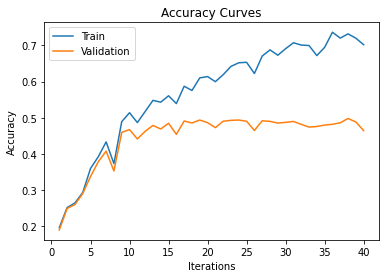

Final Training Accuracy: 0.7018076322249498
Final Validation Accuracy: 0.46406998541970423


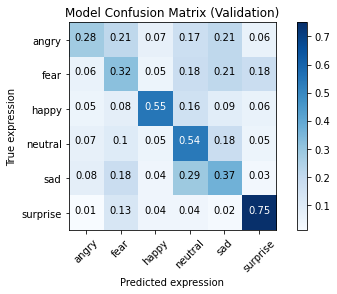

In [36]:
model8c = KLARR_NET8()

if USE_CUDA:
    model8c = model8c.cuda()

train(
    model8c,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=128,
    decay=0.001,
    dropout=True,
    iterations=40
)

Iteration 1: Train loss: 1.7677921402183445, Train accuracy: 0.19741129212229414 | Validation accuracy: 0.19308477400541554
Iteration 2: Train loss: 1.781838366931135, Train accuracy: 0.19941977237223835 | Validation accuracy: 0.18996042491147677
Iteration 3: Train loss: 1.7685355307026343, Train accuracy: 0.1981254184333854 | Validation accuracy: 0.19308477400541554
Iteration 4: Train loss: 1.7751562547954647, Train accuracy: 0.1519750055791118 | Validation accuracy: 0.15163507602582796
Iteration 5: Train loss: 1.7680665918371894, Train accuracy: 0.20731979468868555 | Validation accuracy: 0.20516559050197875
Iteration 6: Train loss: 1.76264538615942, Train accuracy: 0.2124079446552109 | Validation accuracy: 0.2130806082066236
Iteration 7: Train loss: 1.7567966709082776, Train accuracy: 0.21513055121624639 | Validation accuracy: 0.21016454905228077
Iteration 8: Train loss: 1.752445144409483, Train accuracy: 0.19477795135014506 | Validation accuracy: 0.2105811289314726
Iteration 9: Trai

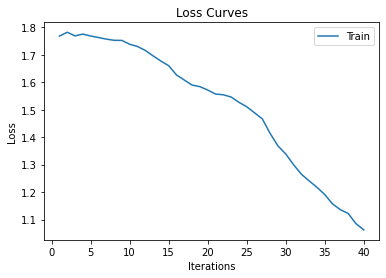

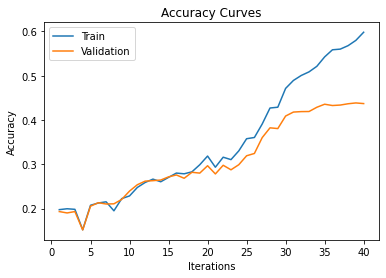

Final Training Accuracy: 0.5981254184333854
Final Validation Accuracy: 0.43699229327223493


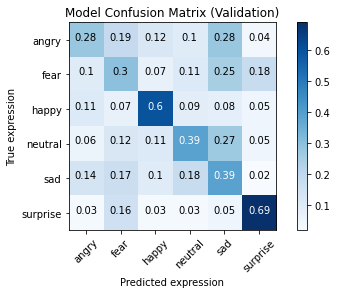

In [37]:
model8d = KLARR_NET8()

if USE_CUDA:
    model8d = model8d.cuda()

train(
    model8d,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=128,
    decay=0.0001,
    dropout=True,
    iterations=40
)

In [38]:
'''
Done architecture tuning. Time for hyperparameter tuning.
Tune DECAY, BATCH SIZE, and LR for current best (8? = ? @ iter ?)
'''

'\nDone architecture tuning. Time for hyperparameter tuning.\nTune DECAY, BATCH SIZE, and LR for current best (8? = ? @ iter ?)\n'

In [39]:
'''
Can further implement early stop based on validation loss, and reduce lr as training goes on
Could also perform transfer learning
'''

'\nCan further implement early stop based on validation loss, and reduce lr as training goes on\nCould also perform transfer learning\n'

Final Model Train Accuracy: 0.7625976344565946
Final Model Validation Accuracy: 0.527806706936055
Final Model Test Accuracy: 0.5256143273635985


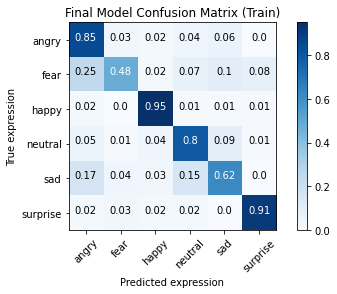

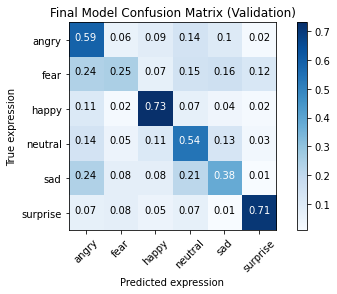

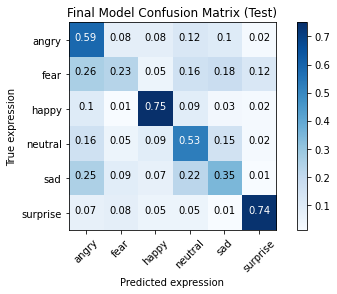

In [40]:
model_final = KLARR_NET7()
model_final.load_state_dict(torch.load("models/model_KLARR_NET7_bs128_lr0.002_iter13_date23_11_2020-03_09"))

if USE_CUDA:
    model_final = model_final.cuda()

model_final.eval()

print("Final Model Train Accuracy:", get_accuracy(model_final, torch.utils.data.DataLoader(train_data, batch_size=128)))
print("Final Model Validation Accuracy:", get_accuracy(model_final, torch.utils.data.DataLoader(valid_data, batch_size=128)))
print("Final Model Test Accuracy:", get_accuracy(model_final, torch.utils.data.DataLoader(test_data, batch_size=128)))

model_final.eval()

plot_confusion_matrix(model_final, train_data, title="Final Model Confusion Matrix (Train)")
plot_confusion_matrix(model_final, valid_data, title="Final Model Confusion Matrix (Validation)")
plot_confusion_matrix(model_final, test_data, title="Final Model Confusion Matrix (Test)")